In [1]:
cpu_count = 100
import os
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={cpu_count}'
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random, jit, vmap

In [2]:
import dmeq

In [3]:
import numpyro
from numpyro.infer import MCMC, Predictive
import numpyro.distributions as dist
import arviz as az

In [4]:
n_chains = 10

In [5]:
key = random.PRNGKey(42)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
def prev_stats(params, eir, eta):
    p = dmeq.default_parameters()
    for k, v in params.items():
        p[k] = v
    p['EIR'] = eir
    p['eta'] = eta
    solution = dmeq.solve(p)
    return jnp.array([
        solution[0, 3:10].sum() / solution[2, 3:10].sum(), # Prev 2 - 10
        solution[0, 10:].sum() / solution[2, 10:].sum(), # Prev 10+
        solution[1, :5].sum() / solution[2, :5].sum(), # Inc 0 - 5
        solution[1, 5:15].sum() / solution[2, 5:15].sum(), # Inc 5 - 15
        solution[1, 15:].sum() / solution[2, 15:].sum() # Inc 15+
    ])

In [7]:
def prev_stats_multisite(params, eirs, etas):
    return jnp.ravel(vmap(prev_stats, in_axes=[None, 0, 0])(params, eirs, etas))

In [8]:
population = 100_000
EIRs = jnp.array([0.05, 3.9, 15., 20., 100., 150., 418.])
key, key_i = random.split(key)
etas = 1. / (random.normal(key_i, shape=EIRs.shape, dtype=jnp.float64) * 2 * 365 + 20*365)

In [9]:
def model(prev=None, impl=prev_stats_multisite):
    # Pre-erythrocytic immunity
    kb = numpyro.sample('kb', dist.TruncatedDistribution(dist.Normal(2., 1.), low=.1, high=10.))
    ub = numpyro.sample('ub', dist.TruncatedDistribution(dist.Normal(5., 1.), low=1., high=10.))
    b0 = numpyro.sample('b0', dist.Beta(1., 1.))
    IB0 = numpyro.sample('IB0', dist.LeftTruncatedDistribution(dist.Normal(50., 10.), low=1.))
    
    # Clinical immunity
    kc = numpyro.sample('kc', dist.Gamma(2., 1.))
    uc = numpyro.sample('uc', dist.Gamma(5., 1.))
    phi0 = numpyro.sample('phi0', dist.Beta(5., 1.))
    phi1 = numpyro.sample('phi1', dist.Beta(1., 2.))
    IC0 = numpyro.sample('IC0', dist.LeftTruncatedDistribution(dist.Normal(100., 10.), low=1.))
    PM = numpyro.sample('PM', dist.Beta(1., 1.))
    dm = numpyro.sample('dm', dist.LeftTruncatedDistribution(dist.Normal(200., 10.), low=0.))
    
    # Detection immunity
    kd = numpyro.sample('kd', dist.Gamma(2., 1))
    ud = numpyro.sample('ud', dist.Gamma(5., 1.))
    d1 = numpyro.sample('d1', dist.Beta(1., 2.))
    ID0 = numpyro.sample('ID0', dist.LeftTruncatedDistribution(dist.Normal(25., 1.), low=1.))
    fd0 = numpyro.sample('fd0', dist.Beta(1., 1.))
    gd = numpyro.sample('gd', dist.Gamma(1., 1.))
    ad0 = numpyro.sample(
        'ad0',
        dist.TruncatedDistribution(dist.Normal(30. * 365., 1.), low=20. * 365., high=40.*365)
    )
    
    # du = numpyro.sample('du', dist.LeftTruncatedDistribution(dist.Normal(50., 1.), low=0.))
    
    # FOIM
    # cd = numpyro.sample('cd', dist.Beta(1., 2.))
    # cu = numpyro.sample('cu', dist.Beta(1., 5.))
    # g_inf = numpyro.sample('g_inf', dist.Gamma(3., 1.))
    
    pred_prev = impl({
        'kb': kb,
        'ub': ub,
        'b0': b0,
        'IB0': IB0,
        'kc': kc,
        'uc': uc,
        'IC0': IC0,
        'phi0': phi0,
        'phi1': phi1,
        'PM': PM,
        'dm': dm,
        'kd': kd,
        'ud': ud,
        'd1': d1,
        'ID0': ID0,
        'fd0': fd0,
        'gd': gd,
        'ad0': ad0,
        # 'rU': 1. / du,
        # 'cd': cd,
        # 'cu': cu,
        # 'g_inf': g_inf
    }, EIRs, etas)
    
    numpyro.sample(
        'obs',
        dist.Independent(
            dist.Binomial(total_count=population, probs=pred_prev),
            1
        ),
        obs=prev
    )

In [10]:
from jax import pmap, tree_map
import jax

n_samples = int(1e5)
def pmap_prior(k):
    return Predictive(model, num_samples=n_samples // cpu_count)(k)

key, *keys = random.split(key, num=cpu_count + 1)
prior = pmap(pmap_prior, in_axes=0)(jnp.stack(keys))
prior = jax.tree_map(lambda x: jnp.reshape(x, (n_samples, -1)), prior)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [11]:
_ = prior.pop('obs')

In [12]:
X, x_def = jax.tree_util.tree_flatten(prior)
X = jnp.concatenate(X, axis=1)

In [13]:
def sample_y(x):
    params = jax.tree_util.tree_unflatten(x_def, x)
    return prev_stats_multisite(params, EIRs, etas)

In [14]:
y = pmap(vmap(jit(sample_y)))(
    jnp.reshape(X, (cpu_count, X.shape[0] // cpu_count,) + X.shape[1:])
)
y = jnp.reshape(y, (X.shape[0],) + y.shape[2:])

In [15]:
def standardise(x, mean, std):
    return (x - mean) / std
    
def inverse_standardise(x, mean, std):
    return x * std + mean

In [16]:
X_mean, X_std = jnp.mean(X, axis=0), jnp.std(X, axis=0)
y_mean, y_std = jnp.mean(y, axis=0), jnp.std(y, axis=0)

X_stand = standardise(X, X_mean, X_std)
y_stand = standardise(y, y_mean, y_std)

In [17]:
from flax import linen as nn
from jax.tree_util import tree_leaves

class Surrogate(nn.Module):
    units: int
    n_hidden: int
    n_output: int

    @nn.compact
    def __call__(self, x):
        layers = [nn.Dense(self.units) for _ in range(self.n_hidden)]
        for i, lyr in enumerate(layers):
            x = lyr(x)
            x = nn.relu(x)
        return nn.Dense(self.n_output)(x)

In [18]:
surrogate_model = Surrogate(units=288, n_hidden=3, n_output=y.shape[1])
surrogate_params = surrogate_model.init(key, X)

In [19]:
from jax.nn import softplus

@jit
def log_cosh(params, x_batched, y_batched):
    # Define a numerically stable log cosh for a single pair (x,y)
    def error(x, y):
        pred = surrogate_model.apply(params, x)
        diff = y - pred
        return jnp.mean(diff + softplus(-2 * diff) - jnp.log(2.))
    # Vectorize the previous to compute the average of the loss on all samples.
    return jnp.mean(vmap(error)(x_batched, y_batched), axis=0)

In [20]:
import optax
from jax import value_and_grad

In [21]:
tx = optax.adam(learning_rate=.001)
opt_state = tx.init(surrogate_params)
loss_grad_fn = value_and_grad(log_cosh)

In [22]:
batch_size = 100
n_batches = X.shape[0] // batch_size
X_batched = jnp.reshape(
    X_stand,
    (n_batches, batch_size) + X.shape[1:]
)
y_batched = jnp.reshape(
    y_stand,
    (n_batches, batch_size) + y.shape[1:]
)

In [23]:
%%time
epochs = 100

for i in range(epochs):
    key, key_i = random.split(key)
    for b in random.permutation(key_i, n_batches, independent=True):
        loss_val, grads = loss_grad_fn(surrogate_params, X_batched[b], y_batched[b])
        updates, opt_state = tx.update(grads, opt_state)
        surrogate_params = optax.apply_updates(surrogate_params, updates)
    if i % 10 == 0:
        print('Loss step {}: '.format(i), log_cosh(surrogate_params, X_stand, y_stand))

Loss step 0:  0.006393997915582859
Loss step 10:  0.0006832622197736471
Loss step 20:  0.000357693322289136
Loss step 30:  0.00022101374348375467
Loss step 40:  0.00034262504349864543
Loss step 50:  0.00028682982002011664
Loss step 60:  0.00033467355404257035
Loss step 70:  0.00017299169101264708
Loss step 80:  0.00018145086746553665
Loss step 90:  0.00014539085503691788
CPU times: user 1h 9min 38s, sys: 8min 40s, total: 1h 18min 19s
Wall time: 29min 31s


In [24]:
def prev_stats_multisite_surrogate(model_params, EIRs, etas):
    return inverse_standardise(
        surrogate_model.apply(
            surrogate_params,
            standardise(
                jax.flatten_util.ravel_pytree(model_params)[0],
                X_mean,
                X_std
            )
        ),
        y_mean,
        y_std
    )

In [25]:
true_values = Predictive(model, num_samples=1)(key)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [26]:
true_values

{'IB0': Array([47.33754857], dtype=float64),
 'IC0': Array([94.54366449], dtype=float64),
 'ID0': Array([25.23934047], dtype=float64),
 'PM': Array([0.1798907], dtype=float64),
 'ad0': Array([10949.58029555], dtype=float64),
 'b0': Array([0.72416149], dtype=float64),
 'd1': Array([0.31989042], dtype=float64),
 'dm': Array([192.18656311], dtype=float64),
 'fd0': Array([0.37611098], dtype=float64),
 'gd': Array([0.25495824], dtype=float64),
 'kb': Array([2.94980955], dtype=float64),
 'kc': Array([1.076653], dtype=float64),
 'kd': Array([3.76847035], dtype=float64),
 'obs': Array([[  690,  1069,     1,     8,    11, 24816, 26092,   242,   378,
           415, 41738, 34977,   746,  1023,  1052, 44598, 36002,   924,
          1275,  1237, 52076, 42607,  2690,  3496,  3891, 52880, 45963,
          3505,  4407,  4777, 57896, 57257,  6078,  7218,  7935]],      dtype=int64),
 'phi0': Array([0.96146541], dtype=float64),
 'phi1': Array([0.63204355], dtype=float64),
 'ub': Array([4.5360091], dtype

In [27]:
observations = true_values['obs'][0]

In [28]:
observations

Array([  690,  1069,     1,     8,    11, 24816, 26092,   242,   378,
         415, 41738, 34977,   746,  1023,  1052, 44598, 36002,   924,
        1275,  1237, 52076, 42607,  2690,  3496,  3891, 52880, 45963,
        3505,  4407,  4777, 57896, 57257,  6078,  7218,  7935],      dtype=int64)

In [29]:
# from numpyro.contrib.tfp.mcmc import RandomWalkMetropolis
# import tensorflow_probability as tfp

In [30]:
n_samples = 100
n_warmup = 500

# kernel = RandomWalkMetropolis(
#     model,
#     new_state_fn=tfp.substrates.jax.mcmc.random_walk_normal_fn(scale=.04)
# )

from numpyro.infer import NUTS

kernel = NUTS(model)

mcmc = MCMC(
    kernel,
    num_samples=n_samples,
    num_warmup=n_warmup,
    num_chains=n_chains,
)
mcmc.run(key, observations, prev_stats_multisite)
mcmc.print_summary(prob=0.7)

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "



                mean       std    median     15.0%     85.0%     n_eff     r_hat
       IB0     52.33      6.62     52.01     45.93     59.33    981.77      1.00
       IC0     99.05      9.58     98.95     88.87    108.06   1349.40      0.99
       ID0     25.40      0.54     25.37     24.82     25.90    681.50      1.01
        PM      0.51      0.29      0.52      0.28      0.97   1222.19      0.99
       ad0  10950.07      0.97  10950.05  10949.20  10951.13   1025.89      1.00
        b0      0.72      0.01      0.72      0.71      0.73    769.37      1.00
        d1      0.32      0.00      0.32      0.31      0.32    795.71      1.00
        dm    198.53      9.64    198.53    189.87    210.05   1146.25      1.00
       fd0      0.49      0.29      0.49      0.13      0.81   1374.47      1.00
        gd      0.22      0.11      0.22      0.13      0.36    499.29      1.02
        kb      2.87      0.49      2.82      2.31      3.30    790.19      1.00
        kc      1.38      0

In [31]:
# kernel = RandomWalkMetropolis(
#     model,
#     new_state_fn=tfp.substrates.jax.mcmc.random_walk_normal_fn(scale=.04)
# )

mcmc_surrogate = MCMC(
    NUTS(model),
    num_samples=n_samples,
    num_warmup=n_warmup,
    num_chains=n_chains,
)
mcmc_surrogate.run(key, observations, prev_stats_multisite_surrogate)
mcmc_surrogate.print_summary(prob=0.7)

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]


                mean       std    median     15.0%     85.0%     n_eff     r_hat
       IB0     17.39     22.02      3.76      1.28     14.89      5.79      3.64
       IC0     25.80     41.64      1.69      1.13      5.61      5.91      6.79
       ID0     15.71     13.80     14.90      1.21     26.93      5.04     25.29
        PM      0.29      0.16      0.26      0.09      0.33     11.87      1.50
       ad0  10961.15     12.07  10959.99  10949.60  10975.64      5.05     14.52
        b0      0.90      0.12      0.98      0.86      1.00      5.66      5.59
        d1      0.39      0.09      0.38      0.30      0.48      5.08     15.88
        dm     61.17     89.79      4.57      0.21    168.61      5.05     16.44
       fd0      0.47      0.32      0.57      0.14      0.83      5.18      6.28
        gd      3.29      5.20      0.93      0.17      2.95      5.15      7.95
        kb      3.16      2.79      2.52      0.10      3.32      5.24      7.08
        kc      2.30      1

In [32]:
prior = Predictive(model, num_samples=600)(key)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [33]:
prior_surrogate = Predictive(model, num_samples=600)(key, impl=prev_stats_multisite_surrogate)

In [34]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(
    model,
    posterior_samples
)(key, observations, prev_stats_multisite)

In [35]:
posterior_samples_surrogate = mcmc_surrogate.get_samples()
posterior_predictive_surrogate = Predictive(
    model,
    posterior_samples_surrogate
)(key, observations, prev_stats_multisite_surrogate)

In [36]:
pyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)

/home/gc1610/projects/eqio/env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [37]:
pyro_data_surrogate = az.from_numpyro(
    mcmc_surrogate,
    prior=prior_surrogate,
    posterior_predictive=posterior_predictive_surrogate
)

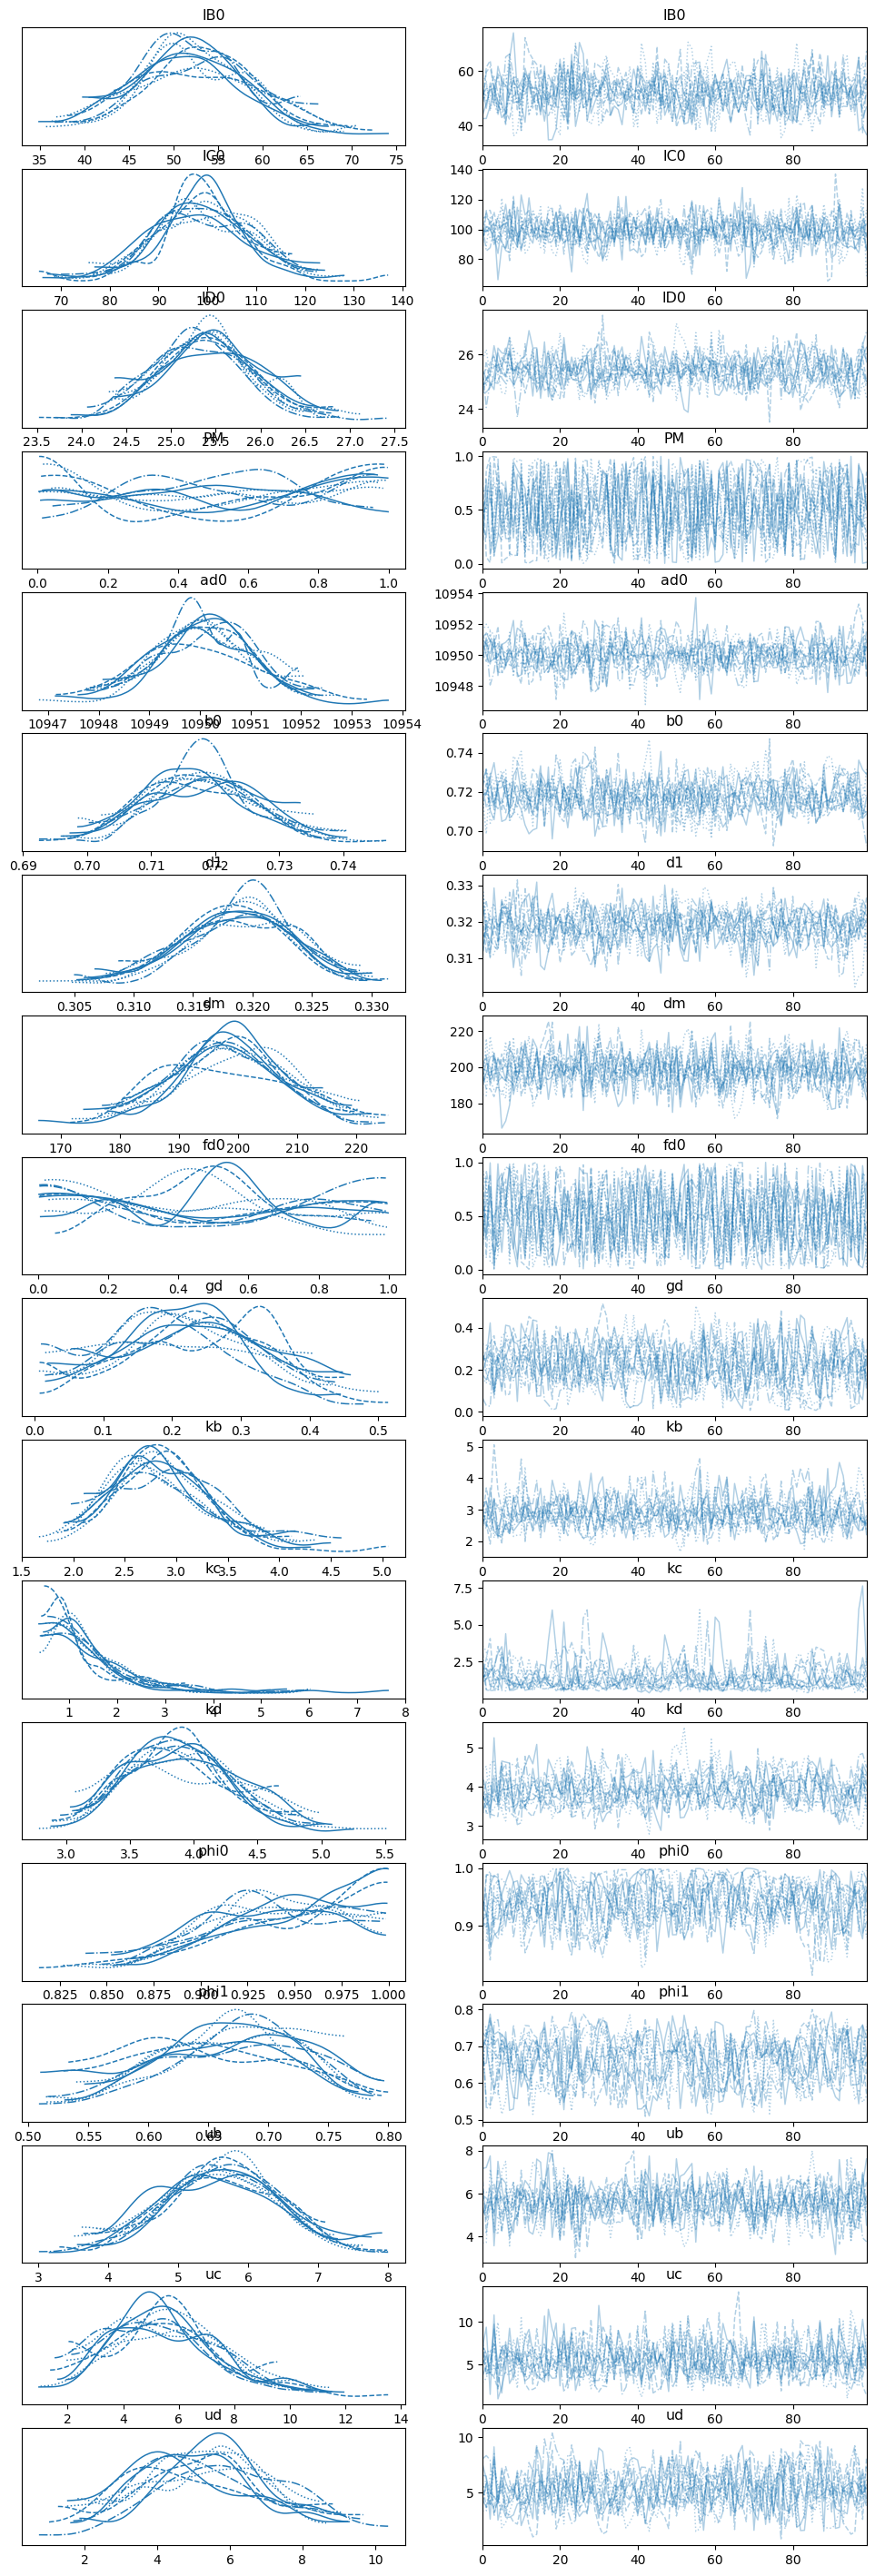

In [38]:
az.rcParams["plot.max_subplots"] = 200
axs = az.plot_trace(pyro_data)

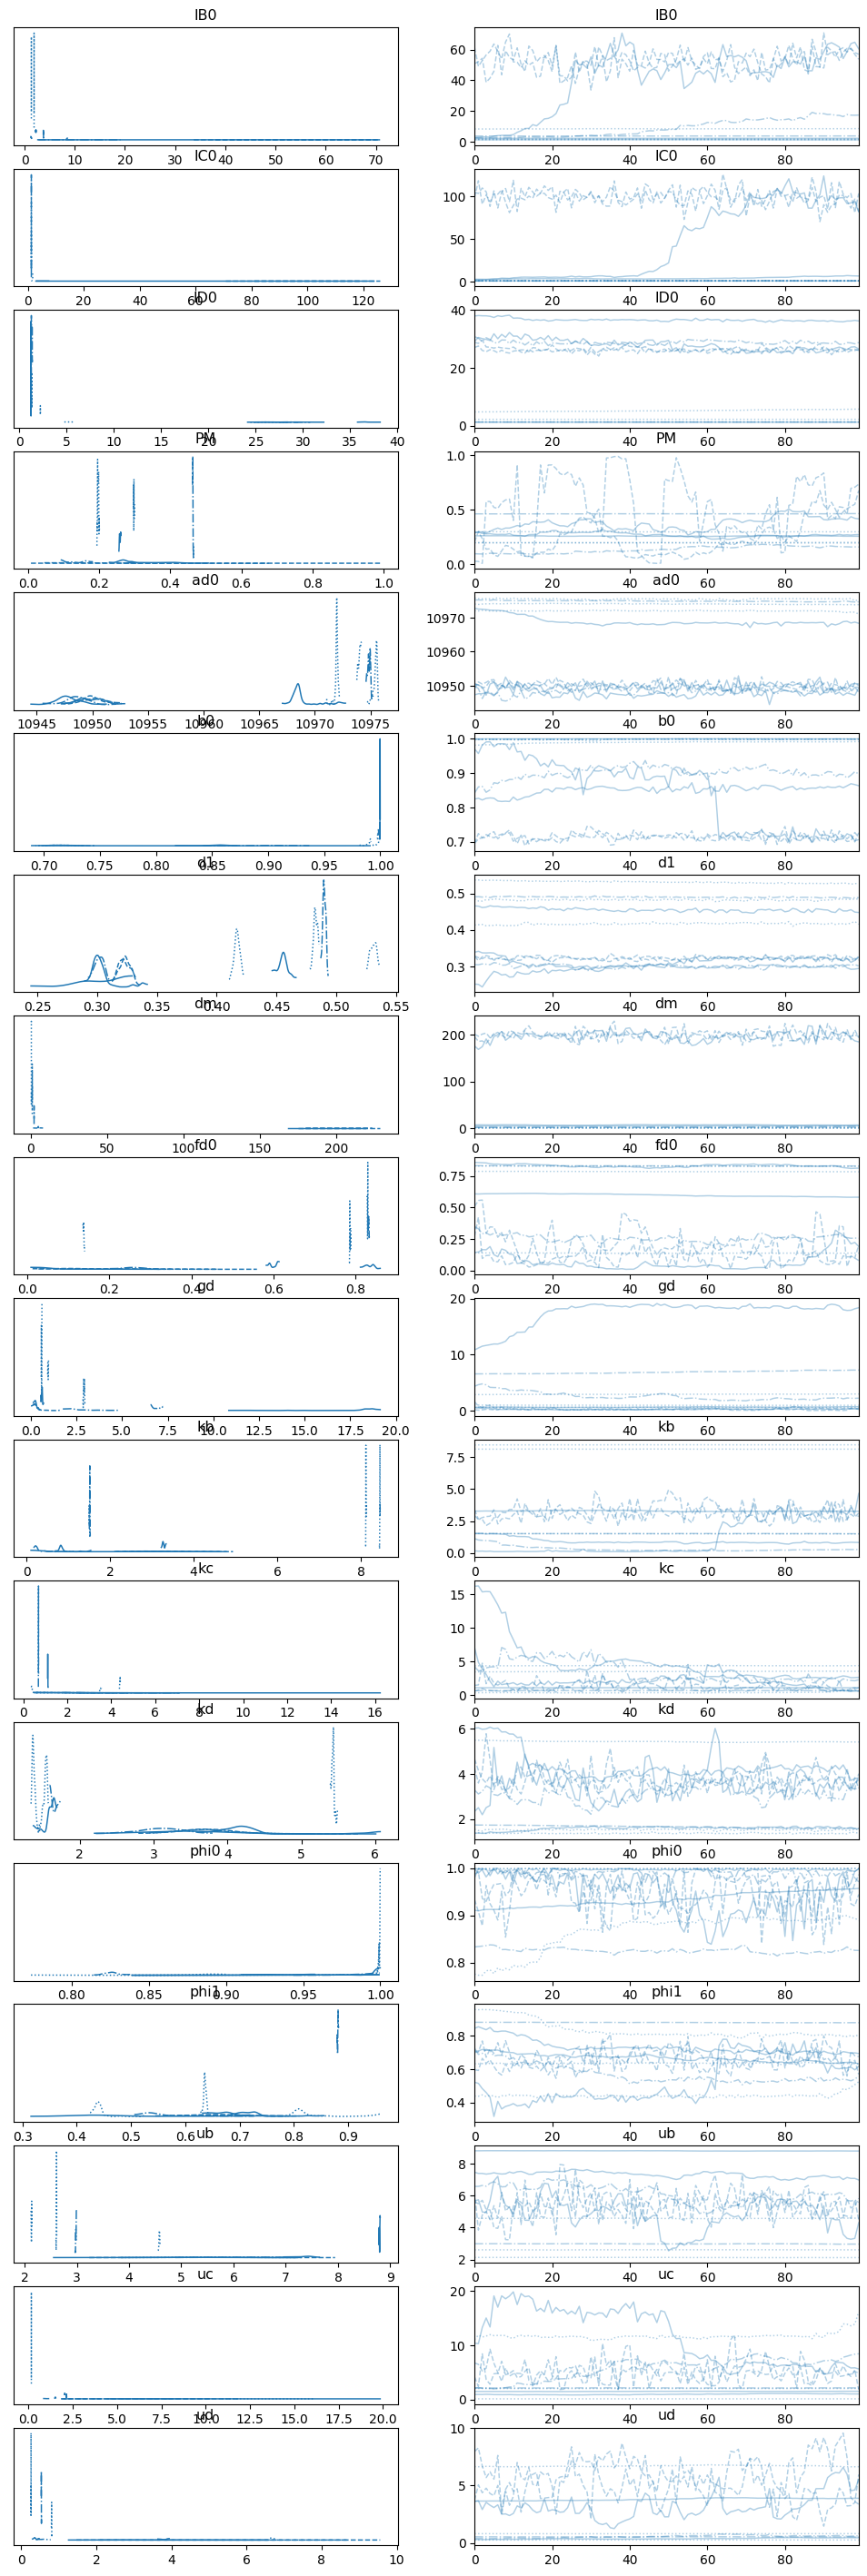

In [39]:
axs = az.plot_trace(pyro_data_surrogate)

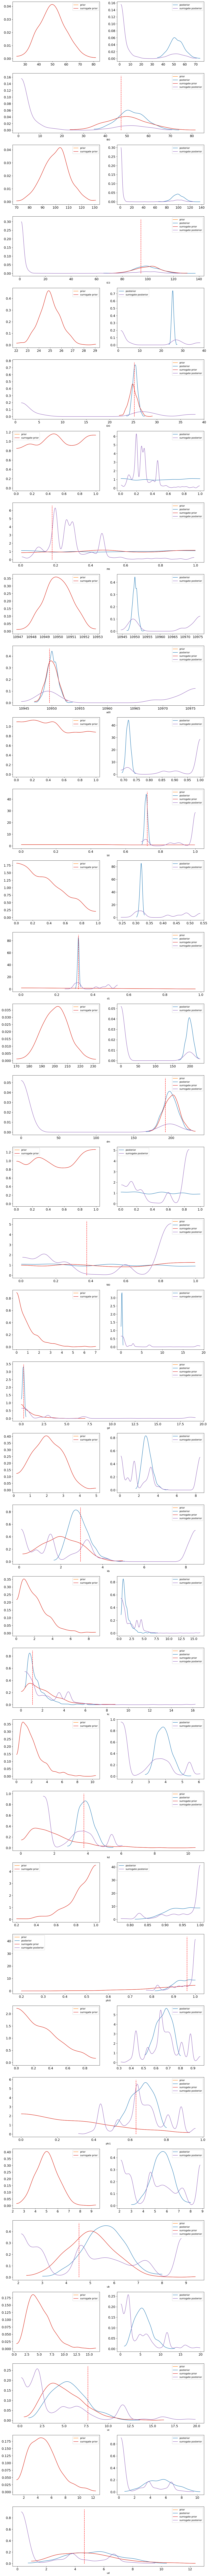

In [40]:
keys = list(pyro_data.prior.data_vars.keys())
axs = az.plot_dist_comparison(pyro_data)
axs = az.plot_dist_comparison(
    pyro_data_surrogate,
    ax=axs
)
for i in range(axs.shape[0]):
    axs[i, 2].vlines(
        true_values[keys[i]][0],
        0,
        axs[i, 2].get_ylim()[1],
        color = 'red',
        linestyle = 'dashed'
    )
    s_prior_lines = [axs[i, 0].get_lines()[1], axs[i, 2].get_lines()[2]]
    s_posterior_lines = [axs[i, 1].get_lines()[1], axs[i, 2].get_lines()[3]]
    for s_prior_line in s_prior_lines:
        s_prior_line.set_color('C3')
        s_prior_line.set_label('surrogate prior')
    for s_posterior_line in s_posterior_lines:
        s_posterior_line.set_color('C4')
        s_posterior_line.set_label('surrogate posterior')
    
    for j in range(3):
        axs[i, j].legend()

In [41]:
from scipy.stats import wasserstein_distance
import pandas as pd

In [42]:
pd.DataFrame({
    'parameter': list(posterior_samples.keys()),
    'Wd': [
        wasserstein_distance(posterior_samples[k], posterior_samples_surrogate[k])
        for k in posterior_samples.keys()
    ]
}).sort_values('Wd')

parameter          Wd
13      phi0    0.023771
14      phi1    0.056968
6         d1    0.081371
8        fd0    0.084712
5         b0    0.183073
3         PM    0.228493
11        kc    0.964548
12        kd    1.097392
15        ub    1.167700
10        kb    1.747443
16        uc    2.374452
17        ud    2.575570
9         gd    3.061513
4        ad0   11.446018
2        ID0   13.061800
0        IB0   34.934095
1        IC0   73.256207
7         dm  137.365453

In [47]:
from matplotlib import cm

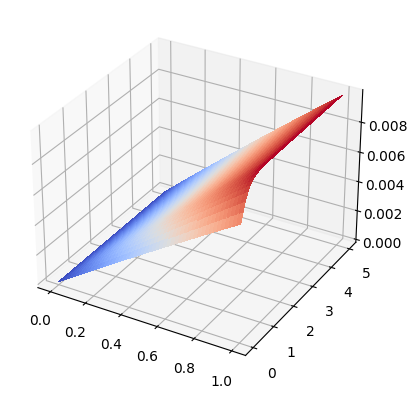

In [54]:
def plot_f(names, values, impl):
    values = jnp.meshgrid(*values)
    p = dict(zip(names, values))
    
    def prev(p, impl):
        return impl(p, EIRs, etas)[0]
    
    prev_space = vmap(
        vmap(
            prev,
            in_axes=({n: 0 for n in names}, None),
            out_axes=0
        ),
        in_axes=({n: 1 for n in names}, None),
        out_axes=1
    )(p, impl)
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    ax.plot_surface(values[0], values[1], prev_space, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

n = 50
plot_f(['b0', 'kb'], [jnp.linspace(0, 1, num=n), jnp.linspace(0, 5, num=n)], prev_stats_multisite)

In [55]:
def plot_f(names, values, impl):
    values = jnp.meshgrid(*values)
    p = dict(zip(names, values))
    
    def prev(p, impl):
        return impl(p, EIRs, etas)[0]
    
    prev_space = vmap(
        vmap(
            prev,
            in_axes=({n: 0 for n in names}, None),
            out_axes=0
        ),
        in_axes=({n: 1 for n in names}, None),
        out_axes=1
    )(p, impl)
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    ax.plot_surface(values[0], values[1], prev_space, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

plot_f(
    ['b0', 'kb'],
    [jnp.linspace(0, 1, num=n), jnp.linspace(0, 5, num=n)],
    prev_stats_multisite_surrogate
)

TypeError: sub got incompatible shapes for broadcasting: (50, 50, 2), (1, 1, 18).

In [52]:
jnp.meshgrid(jnp.linspace(0, 1, num=n), jnp.linspace(0, 5, num=n))[0].shape

(50, 50)